Install Requirements and Import Libaries

In [31]:
# PART 1
! pip install pandas numpy matplotlib seaborn scikit-learn imbalanced-learn mlflow -q

# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from imblearn.over_sampling import SMOTE
import mlflow
import mlflow.sklearn


In [32]:
! git clone https://github.com/samuel29102002/AsteroidPredictionModel.git

fatal: destination path 'AsteroidPredictionModel' already exists and is not an empty directory.


Data Wrangling

In [ ]:

# Load the data
data = pd.read_csv('https://media.githubusercontent.com/media/samuel29102002/AsteroidPredictionModel/main/dataset_all.csv')

# Preprocess the data
def handle_missing_values(data: pd.DataFrame) -> pd.DataFrame:
    selected_columns = ['H', 'diameter',  'q', 'i',  'moid', 'pha']
    data = data[selected_columns]
    for column in selected_columns:
        if data[column].dtype == 'float64':
            data[column].fillna(data[column].mean(), inplace=True)
        elif data[column].dtype == 'object':
            data[column].fillna(data[column].mode()[0], inplace=True)
    return data

data = handle_missing_values(data)


In [47]:
features = data[['H', 'diameter', 'q', 'i', 'moid']]
target = data['pha'].apply(lambda x: 1 if x == 'Y' else 0)

 # Oversample the data
def oversample_data(X: pd.DataFrame, y: pd.Series):
     oversampler = SMOTE(sampling_strategy='minority', random_state=42)
     X_resampled, y_resampled = oversampler.fit_resample(X, y)
     return X_resampled, y_resampled


 # Apply oversampling to the whole dataset
X_oversampled, y_oversampled = oversample_data(features, target)

X_train, X_test, y_train, y_test = train_test_split(X_oversampled, y_oversampled, test_size=0.3, random_state=42)

# Normalize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
print(y_train.value_counts())
print(y_test.value_counts())



1    669651
0    669390
Name: pha, dtype: int64
0    287068
1    286807
Name: pha, dtype: int64


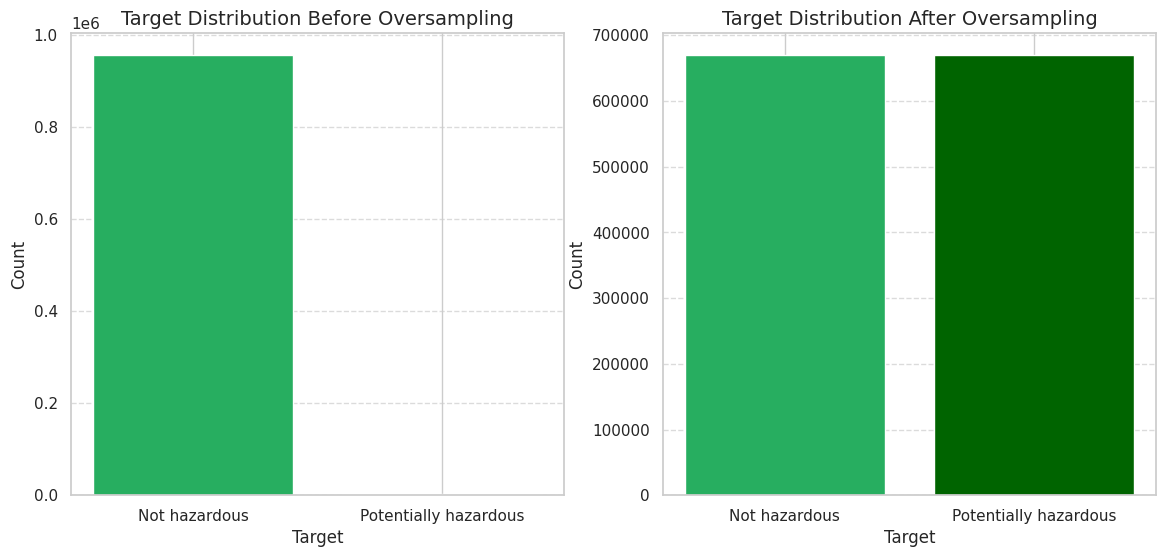

In [58]:
def compare_target_distribution(y_before: pd.Series, y_after: pd.Series, labels: list):
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    y_before_counts = y_before.value_counts()
    y_after_counts = y_after.value_counts()

    # Customize bar colors
    bar_colors = [ '#27AE60','#006400']

    axes[0].bar(labels, y_before_counts, color=bar_colors)
    axes[0].set_title('Target Distribution Before Oversampling', fontsize=14)
    axes[0].set_xlabel('Target', fontsize=12)
    axes[0].set_ylabel('Count', fontsize=12)
    axes[0].grid(axis='y', linestyle='--', alpha=0.7)

    axes[1].bar(labels, y_after_counts, color=bar_colors)
    axes[1].set_title('Target Distribution After Oversampling', fontsize=14)
    axes[1].set_xlabel('Target', fontsize=12)
    axes[1].set_ylabel('Count', fontsize=12)
    axes[1].grid(axis='y', linestyle='--', alpha=0.7)

    # Make background transparent
    fig.patch.set_visible(False)
    axes[0].set_facecolor((1.0, 1.0, 1.0, 0.0))
    axes[1].set_facecolor((1.0, 1.0, 1.0, 0.0))

    plt.show()


labels = ['Not hazardous', 'Potentially hazardous']
compare_target_distribution(target, y_train, labels)


Best Model

In [ ]:
# Load the best model
run_id = "c846938e8b874796aff72d34cc106cbf"
name = "RandomForest_10_50"
# Load the best model
model = mlflow.sklearn.load_model(f"/content/AsteroidPredictionModel/mlruns/0/{run_id}/artifacts")

# Evaluate the model
y_pred = model.predict(X_test)



Showing the results

<Figure size 1500x1500 with 0 Axes>

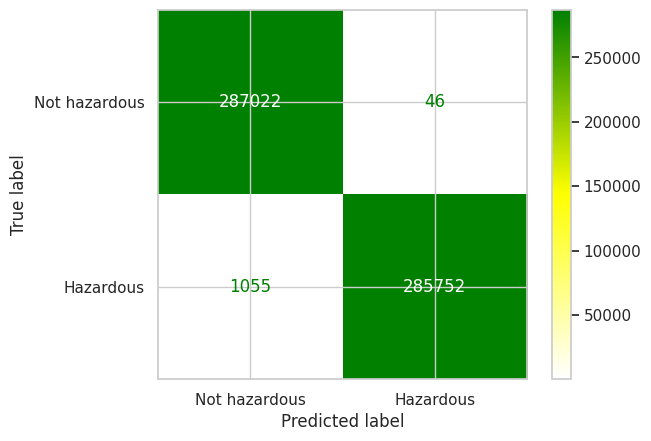

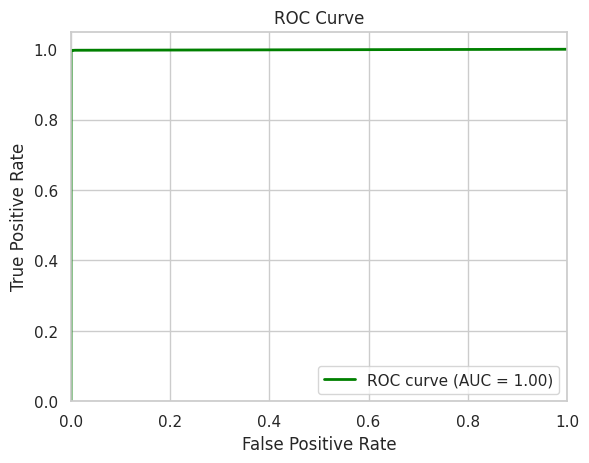

In [54]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, RocCurveDisplay, auc
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# Plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not hazardous', 'Hazardous'])

# Create a custom colormap with a green color scale for accurate predictions
custom_cmap = LinearSegmentedColormap.from_list("my_cmap", [(0, "white"), (0.5, "yellow"), (1, "green")])

plt.figure(figsize=(15, 15))
cm_display.plot(cmap=custom_cmap)  # Pass the custom colormap to the plot function
plt.show()

fig1 = cm_display

fig1.figure_.savefig("confusion_matrix.png", dpi=100)





import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(y_test, y_pred_proba):
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='green', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

# Predict probabilities for the test set
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Plot ROC curve
plot_roc_curve(y_test, y_pred_proba)


In [50]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Extract metrics from the confusion matrix
tn, fp, fn, tp = cm.ravel()

# Calculate the total number of hazardous asteroids and the number of correctly predicted hazardous asteroids
total_hazardous = tp + fn
correctly_predicted_hazardous = tp

# Print the output
print(f"Von {total_hazardous} gefährlichen Asteroiden werden {correctly_predicted_hazardous} richtig vorhergesagt.")
# Calculate the hit rate in percent
hit_rate = (correctly_predicted_hazardous / total_hazardous) * 100

# Print the output
print(f"Das entspricht einer Trefferquote von {hit_rate:.2f} Prozent.")

print('************************************')
# Create a report
report = f"""Confusion Matrix:
True Positive (TP): {tp}
True Negative (TN): {tn}
False Positive (FP): {fp}
False Negative (FN): {fn}

ROC Curve AUC: {roc_auc:.2f}
"""

print(report)


Von 286807 gefährlichen Asteroiden werden 285752 richtig vorhergesagt.
Das entspricht einer Trefferquote von 99.63 Prozent.
************************************
Confusion Matrix:
True Positive (TP): 285752
True Negative (TN): 287022
False Positive (FP): 46
False Negative (FN): 1055

ROC Curve AUC: 0.98

